In [ ]:
import torch
from torch import nn
from torch import optim
from scipy.signal import savgol_filter

class REINFORCE:
    def __init__(self, env, obs_type):
        self.env = env

        if obs_type == 'vector':
          self.state_size = env.observation_space.shape[0]
        elif obs_type == 'pixel':
          self.state_size = self.state_size[0]*self.state_size[1]*self.state_size[2]

        self.action_size = env.action_space.n
        self.hidden_size = 64

        self.policy = torch.nn.Sequential(
            nn.Flatten(start_dim=-1),
            nn.Linear(self.state_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.action_size),
            nn.Softmax(dim=-1)
        )

        self.alpha = 0.001
        self.gamma = 0.9
        self.optim = optim.Adam(self.policy.parameters(), lr=self.alpha)

    def select_action(self, state):
        probs = self.policy(state)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample().item()
        return action

    def compute_returns(self, rewards):
        returns = []
        for step in range(len(rewards)):
            G = 0.0
            for k, r in enumerate(rewards[step:]):
                G += (self.gamma ** k) * r
            returns.append(G)

        return returns

    def update(self, states, actions, returns):
        for state, action, G in zip(states, actions, returns):
            probs = self.policy(state)
            dist = torch.distributions.Categorical(probs=probs)
            log_prob = dist.log_prob(action)
            entropy = dist.entropy()
            weight = 0.01

            loss = -log_prob * G + weight * entropy

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

    def train(self, episodes):
        episode = 0
        self.episode_rewards=[]
        while episode <= episodes:
            state = torch.tensor(self.env.reset(), dtype=torch.float).flatten()

            done = False
            actions, states, rewards = [], [], []
            total_rewards = 0
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action)

                actions.append(torch.tensor(action, dtype=torch.int))
                states.append(state)
                rewards.append(reward)
                total_rewards += reward

                state = torch.tensor(next_state, dtype=torch.float).flatten()

            returns = self.compute_returns(rewards)
            self.update(states, actions, returns)

            if episode % 100 == 0:
                print(f"Episode: {episode}, Reward: {total_rewards}")
            self.episode_rewards.append(total_rewards)
           
            episode += 1
        
        self.episode_rewards = savgol_filter(self.episode_rewards, window_length = 50, polyorder=2 )
        plt.plot(self.episode_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("REINFORCE Rewards over Episodes")
        plt.show()

Catch:


Episode: 0, Reward: -8.0
Episode: 100, Reward: -8.0
Episode: 200, Reward: -7.0
Episode: 300, Reward: -7.0
Episode: 400, Reward: 29.0
Episode: 500, Reward: 33.0
Episode: 600, Reward: 35.0
Episode: 700, Reward: 35.0
Episode: 800, Reward: 35.0
Episode: 900, Reward: 35.0
Episode: 1000, Reward: 35.0
Episode: 1100, Reward: 35.0
Episode: 1200, Reward: 35.0
Episode: 1300, Reward: 35.0
Episode: 1400, Reward: 35.0
Episode: 1500, Reward: 35.0
Episode: 1600, Reward: 35.0
Episode: 1700, Reward: 35.0
Episode: 1800, Reward: 35.0
Episode: 1900, Reward: 35.0
Episode: 2000, Reward: 35.0


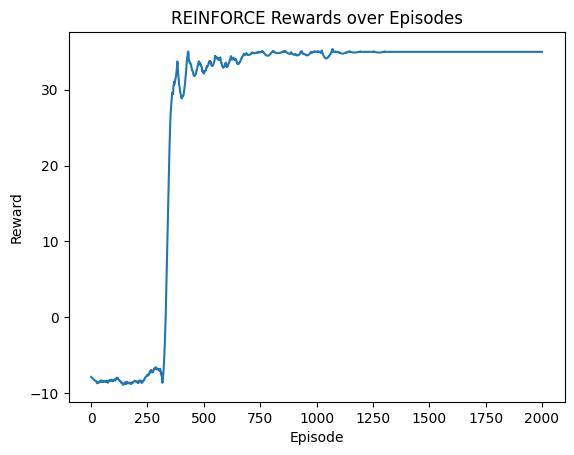

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import matplotlib
import torch

# matplotlib.use('TkAgg')  # 'Qt5Agg') # 'TkAgg'
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from gym import spaces

ACTION_EFFECTS = (-1, 0, 1)  # left, idle right.
OBSERVATION_TYPES = ['pixel', 'vector']


class Catch():
    

    def __init__(self, rows: int = 7, columns: int = 7, speed: float = 1.0,
                 max_steps: int = 250, max_misses: int = 10,
                 observation_type: str = 'pixel', seed=None,
                 ):
        """ Arguments: 
        rows: the number of rows in the environment grid.
        columns: number of columns in the environment grid.
        speed: speed of dropping new balls. At 1.0 (default), we drop a new ball whenever the last one drops from the bottom. 
        max_steps: number of steps after which the environment terminates.
        max_misses: number of missed balls after which the environment terminates (when this happens before 'max_steps' is reached).
        observation_type: type of observation, either 'vector' or 'pixel'. 
              - 'vector': observation is a vector of length 3:  [x_paddle,x_lowest_ball,y_lowest_ball]
              - 'pixel': observation is an array of size [rows x columns x 2], with one hot indicator for the paddle location in the first channel,
              and one-hot indicator for every present ball in the second channel. 
        seed: environment seed. 
        """
        if observation_type not in OBSERVATION_TYPES:
            raise ValueError('Invalid "observation_type". Needs to be in  {}'.format(OBSERVATION_TYPES))
        if speed <= 0.0:
            raise ValueError('Dropping "speed" should be larger than 0.0')

        # store arguments
        self._rng = np.random.RandomState(seed)
        self.rows = rows
        self.columns = columns
        self.speed = speed
        self.max_steps = max_steps
        self.max_misses = max_misses
        self.observation_type = observation_type

        # compute the drop interval 
        self.drop_interval = max(1, rows // speed)  # compute the interval towards the next drop, can never drop below 1
        if speed != 1.0 and observation_type == 'vector':
            print(
                'Warning: You use speed > 1.0, which means there may be multiple balls in the screen at the same time.' +
                'However, with observation_type = vector, only the xy location of *lowest* ball is visible to the agent' +
                ' (to ensure a fixed length observation vector')

        # Initialize counter
        self.total_timesteps = None
        self.fig = None
        self.action_space = spaces.Discrete(3, )
        if self.observation_type == 'vector':
            self.observation_space = spaces.Box(low=np.array((0, 0, 0)),
                                                high=np.array((self.columns, self.columns, self.rows)), dtype=int)
        elif self.observation_type == 'pixel':
            self.observation_space = spaces.Box(low=np.zeros((self.rows, self.columns, 2)),
                                                high=np.ones((self.rows, self.columns, 2)), dtype=int)

    def reset(self):
        ''' Reset the problem to empty board with paddle in the middle bottom and a first ball on a random location in the top row '''
        # reset all counters
        self.total_timesteps = 0
        self.total_reward = 0
        self.r = '-'
        self.missed_balls = 0
        self.time_till_next_drop = self.drop_interval
        self.terminal = False

        # initialized problem
        self.paddle_xy = [self.columns // 2, 0]  # paddle in the bottom middle
        self.balls_xy = []  # empty the current balls
        self._drop_new_ball()  # add the first ball
        s0 = self._get_state()  # get first state
        return s0

    def step(self, a):
        ''' Forward the environment one step based on provided action a '''

        # Check whether step is even possible
        if self.total_timesteps is None:
            ValueError("You need to reset() the environment before you can call step()")
        elif self.terminal:
            ValueError("Environment has terminated, you need to call reset() first")

        # Move the paddle based on the chosen action
        self.paddle_xy[0] = np.clip(self.paddle_xy[0] + ACTION_EFFECTS[a], 0, self.columns - 1)

        # Drop all balls one step down
        for ball in self.balls_xy:
            ball[1] -= 1

        # Check whether lowest ball dropped from the bottom
        if len(self.balls_xy) > 0:  # there is a ball present
            if self.balls_xy[0][1] < 0:  # the lowest ball reached below the bottom
                del self.balls_xy[0]

        # Check whether we need to drop a new ball
        self.time_till_next_drop -= 1
        if self.time_till_next_drop == 0:
            self._drop_new_ball()
            self.time_till_next_drop = self.drop_interval

            # Compute rewards
        if (len(self.balls_xy) == 0) or (self.balls_xy[0][1] != 0):  # no ball present at bottom row
            r = 0.0
        elif self.balls_xy[0][0] == self.paddle_xy[0]:  # ball and paddle location match, caught a ball
            r = 1.0
        else:  # missed the ball
            r = -1.0
            self.missed_balls += 1

        # Compute termination
        self.total_timesteps += 1
        if (self.total_timesteps == self.max_steps) or (self.missed_balls == self.max_misses):
            self.terminal = True
        else:
            self.terminal = False

        self.r = r
        self.total_reward += r
        return self._get_state(), r, self.terminal #, {}

    def render(self, step_pause=0.3):
        ''' Render the current environment situation '''
        if self.total_timesteps is None:
            ValueError("You need to reset() the environment before you render it")

        # In first call initialize figure
        if self.fig == None:
            self._initialize_plot()

        # Set all colors to white
        for x in range(self.columns):
            for y in range(self.rows):
                if self.paddle_xy == [x, y]:  # hit the agent location
                    if [x, y] in self.balls_xy:  # agent caught a ball
                        self.patches[x][y].set_color('g')
                    else:
                        self.patches[x][y].set_color('y')
                elif [x, y] in self.balls_xy:  # hit a ball location without agent
                    if y == 0:  # missed the ball
                        self.patches[x][y].set_color('r')
                    else:  # just a ball
                        self.patches[x][y].set_color('w')
                else:  # empty spot
                    self.patches[x][y].set_color('k')
        # plt.axis('off')

        self.label.set_text(
            'Reward:  {:<5}            Total reward:  {:<5}     \nTotal misses: {:>2}/{:<2}     Timestep: {:>3}/{:<3}'.format(
                self.r, self.total_reward, self.missed_balls, self.max_misses, self.total_timesteps, self.max_steps))

        # Draw figure
        plt.pause(step_pause)

    def _initialize_plot(self):
        ''' initializes the catch environment figure '''
        self.fig, self.ax = plt.subplots()
        self.fig.set_figheight(self.rows)
        self.fig.set_figwidth(self.columns)
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.set_xlim([0, self.columns])
        self.ax.set_ylim([0, self.rows])
        self.ax.axes.xaxis.set_visible(False)
        self.ax.axes.yaxis.set_visible(False)

        self.patches = [[[] for x in range(self.rows)] for y in range(self.columns)]
        for x in range(self.columns):
            for y in range(self.rows):
                self.patches[x][y] = Rectangle((x, y), 1, 1, linewidth=0.0, color='k')
                self.ax.add_patch(self.patches[x][y])

        self.label = self.ax.text(0.01, self.rows + 0.2, '', fontsize=20, c='k')

    def _drop_new_ball(self):
        ''' drops a new ball from the top '''
        self.balls_xy.append([self._rng.randint(self.columns), self.rows - 1])  # 0])

    def _get_state(self):
        ''' Returns the current agent observation '''
        if self.observation_type == 'vector':
            if len(self.balls_xy) > 0:  # balls present
                s = np.append(self.paddle_xy[0], self.balls_xy[0]).astype('float32')  # paddle xy and ball xy
            else:
                s = np.append(self.paddle_xy[0], [-1, -1]).astype(
                    'float32')  # no balls, impute (-1,-1) in state for no ball present
        elif self.observation_type == 'pixel':
            s = np.zeros((self.columns, self.rows, 2), dtype=np.float32)
            s[self.paddle_xy[0], self.paddle_xy[1], 0] = 1.0  # set paddle indicator in first slice
            for ball in self.balls_xy:
                s[ball[0], ball[1], 1] = 1.0  # set ball indicator(s) in second slice
        else:
            raise ValueError('observation_type not recognized, needs to be in {}'.format(OBSERVATION_TYPES))
        return s


if __name__ == '__main__':

    obs_type = 'vector'
    env = Catch(rows=7, columns=7, speed=1.0, max_steps=250, max_misses=10, observation_type=obs_type, seed=None)
   
    episodes = 2000

    agentR = REINFORCE(env, obs_type)
    agentR.train(episodes)

